In [18]:
from mixmil.paths import DATA
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
import anndata as ad
import random
from mixmil import MixMIL
import torch
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import scipy.stats as st

import scanpy as sc

In [4]:
# read integrated data
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/seaad_rosmap_integrated_harmonized.h5ad')

# define parameters
sample_key = 'Donor_ID'
classification_keys = "apoe_label"
z_dim = 16
categorical_covariate_keys = [classification_keys] + [sample_key]
seed = 0

# create new adata with multigrate embeddings
new_adata = ad.AnnData(X=adata.obsm['X_multigrate'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()
new_adata = new_adata[~new_adata.obs.apoe_label.isna()]

# stratified sampling by category 
query_samples = []
query_proportion = 0.2
for cat in new_adata.obs[classification_keys].unique():
    adata_cat = new_adata[new_adata.obs[classification_keys] == cat]
    samples = list(np.unique(adata_cat.obs[sample_key]))
    n_samples = len(samples)
    random.seed(seed)
    query_samples.extend(random.sample(samples, int(n_samples * query_proportion)))
    
print(query_samples)

# separate query and training adata
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

# sort index in both training adata and query 
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()
idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

['R4917253', 'R9976232', 'R5415701', 'H20.33.036', 'R3121235', 'R6622577', 'R6268135', 'R5138383', 'R3825485', 'R6163933', 'R4345802', 'R7483736', 'R2565200', 'R6476704', 'R1262106', 'R3426726', 'R9936070', 'H21.33.032', 'R7915228', 'R3035452', 'R6847727', 'R9145673', 'R7738727', 'R1476204', 'R3857927', 'H21.33.036', 'R9566976', 'H21.33.015', 'R8799615', 'R4042599', 'R6114572', 'R7095349', 'H21.33.037', 'R4323608', 'R5636935', 'R3874626', 'R7876628', 'R8202775', 'R2393217', 'R7054373', 'R5739959', 'R6698302', 'R3128463', 'H21.33.005', 'R7039412', 'H20.33.015', 'H21.33.028', 'R9354381', 'R5079327', 'R9210731', 'R8635714', 'R7995082', 'H19.33.004', 'R7881801', 'R6289070', 'R4053976', 'R2881301', 'R3978789', 'R9116123', 'H21.33.007', 'R2124216', 'R7286984', 'R2577726', 'R2879330', 'R1327471', 'R7015250', 'R5883172', 'H21.33.025', 'H21.33.019', 'R3922205', 'R6600608', 'R6284240', 'H21.33.043', 'R3814553', 'R3607578', 'R1074668', 'R6913259', 'R7516349', 'R7384738', 'R8075334', 'H21.33.026',

In [48]:
train_adata = adata.copy()
test_adata = query.copy()

In [49]:
# sex_dict = dict(zip(train_adata.obs['Donor_ID'], train_adata.obs['Sex']))
# test_sex_dict = dict(zip(test_adata.obs['Donor ID'], test_adata.obs['Sex']))

In [50]:
train_adata.obs["apoe_label"] = train_adata.obs["apoe_label"].astype('int64')
test_adata.obs["apoe_label"] = test_adata.obs["apoe_label"].astype('int64')

In [51]:
# prepare train data
train_bags = train_adata.obs["Donor_ID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["Donor_ID"] == bag].X) for bag in train_bags]
# F = torch.Tensor([[1 if sex_dict[bag] == 'Female' else 0] for bag in train_bags]) # fixed effects for sex
F = torch.ones((len(train_bags), 1))
Y = torch.Tensor(train_adata.obs[["Donor_ID", "apoe_label"]].drop_duplicates().set_index("Donor_ID").loc[train_bags].values)

In [52]:
# prepare test data, following official train-test split
test_bags = test_adata.obs["Donor_ID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["Donor_ID"] == bag].X) for bag in test_bags]
# test_F = torch.Tensor([[1 if test_sex_dict[bag] == 'Female' else 0] for bag in test_bags])
test_Y = torch.Tensor(test_adata.obs[["Donor_ID", "apoe_label"]].drop_duplicates().set_index("Donor_ID").loc[test_bags].values)

In [53]:
# initialize model with mean model and Bernoulli likelihood
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical", mean_field=True)
y_pred_mean = model.predict(test_Xs)
y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
print(
    "Macro_F1",
    f1_score(test_Y, y_pred_labels, average="macro"),
    "Spearman:",
    round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
)

/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro_F1 0.2566742252456538 Spearman: 0.108


In [54]:
def to_device(el, device):
    """
    Move a nested structure of elements (dict, list, tuple, torch.Tensor, torch.nn.Module) to the specified device.

    Parameters:
    - el: Element or nested structure of elements to be moved to the device.
    - device (torch.device): The target device, such as 'cuda' for GPU or 'cpu' for CPU.

    Returns:
    - Transferred element(s) in the same structure: Elements moved to the specified device.
    """
    if isinstance(el, dict):
        return {k: to_device(v, device) for k, v in el.items()}
    elif isinstance(el, (list, tuple)):
        return [to_device(x, device) for x in el]
    elif isinstance(el, (torch.Tensor, torch.nn.Module)):
        return el.to(device)
    else:
        return el

In [55]:
# train model for 1000 epochs
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
history = model.train(Xs, F, Y, n_epochs=1000, batch_size = 16, lr = 1e-4)
model.to("cpu")
test_Xs = [x.cpu() for x in test_Xs]
y_pred = model.predict(test_Xs).cpu().numpy()
y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
y_true = test_Y.cpu().numpy()
print(
    "Macro_F1",
    f1_score(y_true, y_pred_labels, average="macro"),
    "Spearman:",
    round(st.spearmanr(y_true, y_pred_labels).correlation, 3),
)

Epoch: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [07:14<00:00,  2.30it/s]


Macro_F1 0.2566742252456538 Spearman: 0.108


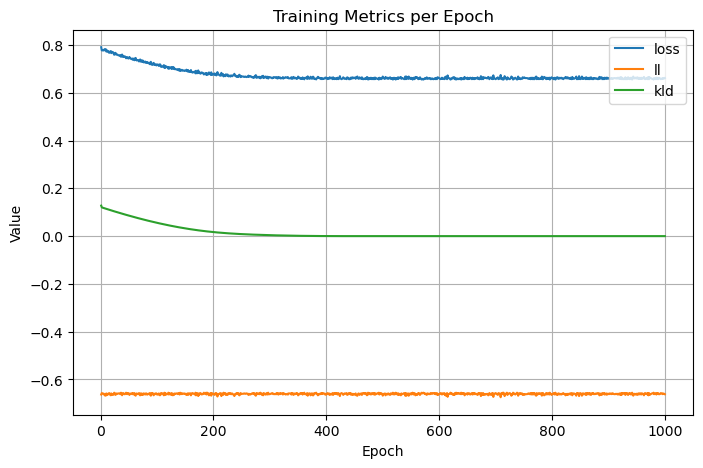

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique epochs
epochs = sorted(set(d['epoch'] for d in history))

# Compute average values per epoch
metrics = {m: [np.mean([d[m] for d in history if d['epoch'] == e]) for e in epochs] 
           for m in ['loss', 'll', 'kld']}

# Plot
plt.figure(figsize=(8, 5))
for metric, values in metrics.items():
    plt.plot(epochs, values, label=metric)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()
